# Introdução
Esse é uma análise feita a título de estudo pessoal, com base no famoso dataset do Titanic: https://www.kaggle.com/c/titanic.
Na primeira etapa desse notebook será feita uma análise exploratória dos dados, o que consiste em uma etapa anterior ao processo de previsão, para determinação das features mais relevantes na sobrevivência dos passageiros, e também para tratamento dos dados categóricos e missing values. Posteriormente será feito o ajuste de um modelo e submissão da previsão de sobrevivência no Titanic.

# Análise e Transformação dos Dados

In [1]:
# Bibliotecas para análise dos dados
import pandas as pd 
import numpy as np 

In [2]:
# Criando dataframe com os dados de Treino
df = pd.read_csv("../input/titanic/train.csv")

# Visualização inicial do dataframe
print(f'Número de Linhas e Colunas: {df.shape}')
df.head()

Número de Linhas e Colunas: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Alterar o nome das colunas para facilitar o entendimento 
df.columns = ["Id", "Sobreviveu", "Classe", "Nome", "Sexo", "Idade", "Familiares", "Dependentes", "Ticket", "Preço da Passagem", "Cabine", "Local de Embarque"]
df.head()

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Dicionário dos Dados**:

**ID**: Identificador do Passageiro (int)

**Sobreviveu**: Se o passageiro sobreviveu (0 = Não, 1 = Sim)

**Classe**: Classe na qual o passageiro viajou. (1 = Primeira Classe, 2 = Segunda Classe, 3 = Terceira Classe)

**Nome**: Nome do passageiro, com o pronome de tratamento

**Sexo**: Sexo do passageiro (Male, Female)

**Idade**: Idade do passageiro (float)

**Familiares**: Quantidade de irmãos e cônjuges relativos ao passageiro

**Dependentes**: Quantidade de Filhos ou Pais (idosos) relativos ao passageiro

**Ticket**: Número do bilhete do passageiro

**Preço da Passagem**: Valor pago pelo passageiro para viajar (Dólar)

**Cabine**: Número da Cabine do passageiro

**Local de Embarque**: Foram 3 paradas antes de seguir para Nova York (C = Cherbourg, Q = Queenstown, S = Southampton)

In [4]:
# Avaliar a distribuição da classe Target (Sobreviveu)
df.Sobreviveu.value_counts(normalize=True)*100

0    61.616162
1    38.383838
Name: Sobreviveu, dtype: float64

Á classe alvo está desbalanceada, mas não de forma severa. O impacto disso pode ser avaliado através da matriz de confusão, despois da previsão. Por mais que a submissão avalie somente a acurácia (que não detecta erros tipo II), é importante considerar o impacto desse erro e buscar uma métrica adequada (F1, talvez) em situações de classes desbalanceadas.
Outra questão é que todas as análises ficaram desbalanceadas, não devendo este comportamento ser confundido totalmente com correlação.

In [5]:
# Avaliar a distribuição da Target por Sexo
df.groupby('Sexo')['Sobreviveu'].value_counts(normalize=True).sort_index()*100

Sexo    Sobreviveu
female  0             25.796178
        1             74.203822
male    0             81.109185
        1             18.890815
Name: Sobreviveu, dtype: float64

É bem claro que o Sexo do passageiro foi um dos fatores determinantes na sua sobreviência. **74% das mulheres** que estavam no Titanic sobreviveram, enquanto apenas **19% dos homens** sobreviveram. Vamos avaliar se a Classe em que o passageiro viaja está relacionada à sobrevivência.

In [6]:
# Avaliar a distribuição da Target por Classe
df.groupby('Classe')['Sobreviveu'].value_counts(normalize=True).sort_index()*100

Classe  Sobreviveu
1       0             37.037037
        1             62.962963
2       0             52.717391
        1             47.282609
3       0             75.763747
        1             24.236253
Name: Sobreviveu, dtype: float64

Podemos identificar uma clara correlação entre a Classe em que o passageiro estava e sua probabilidade de sobreviver: sendo que **63%** da Primeira classe sobreviveu, **47%** da Segunda classe e apenas **24%** da Terceira classe.

In [7]:
# Avaliação Geral dos Dados
df.describe()

,Id,Sobreviveu,Classe,Idade,Familiares,Dependentes,Preço da Passagem
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# Avaliar a distribuição dos passageiros pelas Classes do Navio
df.Classe.value_counts(normalize=True).sort_index()*100

1    24.242424
2    20.650954
3    55.106622
Name: Classe, dtype: float64

In [9]:
# Avaliar a distribuição dos passageiros por Sexo
df.Sexo.value_counts(normalize=True)*100

male      64.758698
female    35.241302
Name: Sexo, dtype: float64

**Analisando os dados iniciais, podemos perceber algumas características gerais dos passageiros do Titanic**:

**1)** Haviam no navio desde bebês, com menos de um ano de vida, até idosos, sendo que o passageiro mais velho tinha 80 anos. Mas em geral os passageiros eram mais jovens, sendo a média de idade de 29,7 anos, e 75% dos passageiros tendo até 38 anos.

**2)** O preço da passagem variou bastante, provavelmente em função da classe em que o passageiro viajava. O valor médio da passagem paga para viajar no Titanic foi de 32,20 dólares, mas 75% dos passageiros pagaram até 31 dólares. Os bilhetes mais caros custaram 512 dólares.

**3)** A grande maioria dos passageiros viajava sem familiares (marido, esposa ou irmão) e não tinham dependentes (filhos e pais idosos).

**4)** Mais da metade dos passageiros (55%) viajava na terceira classe. A segunda classe tinha menos passageiros que a primeira.

**5)** Praticamente 65% dos passageiros eram homens.

**6)** As mulheres sobrevivem em proporção muito maior que os homens.

**7)** Existe uma correlação entre a Classe do passageiro e sua probabilidade de sobreviver.

In [10]:
# Avaliar a existência de valores faltantes
df.isnull().sum()

Id                     0
Sobreviveu             0
Classe                 0
Nome                   0
Sexo                   0
Idade                177
Familiares             0
Dependentes            0
Ticket                 0
Preço da Passagem      0
Cabine               687
Local de Embarque      2
dtype: int64

In [11]:
# Proporção de passageiros sem o registro da Idade
((df.Idade.isnull().sum())/df.shape[0])*100

19.865319865319865

20% dos passageiros da base estão sem a indicação da idade. Uma forma de corrigir esse dado é substituir a idade faltante pela média das idades, ou uma média para homens e uma média para mulheres. Caso a própria informação da Falta da idade seja relevante, podemos deixar isso como uma informação discreta, simplificando o ajuste do modelo.

<AxesSubplot:xlabel='Idade', ylabel='Count'>

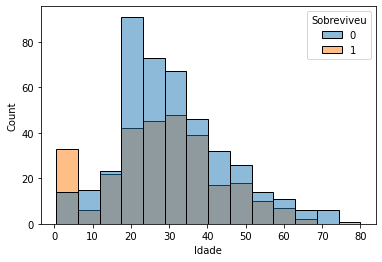

In [12]:
# Avaliar a distribuição da classe Target pela Idade, a fim de validar alguma correlação
import seaborn as sns
sns.histplot(data=df.Sobreviveu, x=df.Idade, hue=df.Sobreviveu, bins=14)

In [13]:
# Criar nova coluna para as Faixas Etárias (criar também na base de teste)
conditions = [
    (df['Idade'] <= 6.0),
    (df['Idade'] > 6.0),
    (df['Idade'].isnull())]
choices = [0, 1, 2]
df['Faixa Etária'] = np.select(conditions, choices)

In [14]:
# Avaliar a distriuição da Sobrevivência entre as Faixas Etárias criadas
df.groupby('Faixa Etária')['Sobreviveu'].value_counts(normalize=True).sort_index()*100

Faixa Etária  Sobreviveu
0             0             29.787234
              1             70.212766
1             0             61.469265
              1             38.530735
2             0             70.621469
              1             29.378531
Name: Sobreviveu, dtype: float64

É bastante diferente a distribuição da sobrevivência para passageiros que tinham o registro da idade e para os que não tinham. Além disso é perceptível que a única faixa etária com volume relevante de passageiros e que foi determinante para a sobreviência, foi a faixa etária de crianças pequenas. Dessa forma, serão criadas 3 faixas etárias para os passageiros: **0**: Crianças de 0 a 6 anos, **1**: Passageiros acima dos 6 anos e **2**: Passegeiros sem o registro da idade. Este procedimento pode ser mais adequado, uma vez que foi percebida uma correlação clara entre a Idade e a Sobrevivência, para justificar deixar a idade como variável contínua.

<AxesSubplot:xlabel='Preço da Passagem', ylabel='Count'>

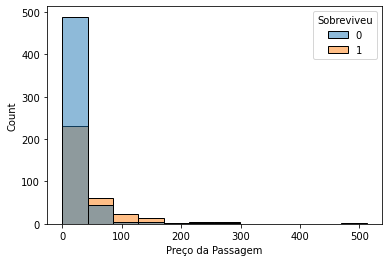

In [15]:
# Avaliar a distribuição da classe Target pelo Preço da Passagem, a fim de validar alguma correlação
import seaborn as sns
sns.histplot(data=df.Sobreviveu, x=df['Preço da Passagem'], hue=df.Sobreviveu, bins=12)

In [16]:
# Criar nova coluna para a Renda (criar também na base de teste)
conditions = [
    (df['Preço da Passagem'] <= 48.0),
    (df['Preço da Passagem'] > 48.0)]
choices = [0, 1]
df['Renda'] = np.select(conditions, choices)

In [17]:
# Avaliar a distriuição da Sobrevivência entre as Faixas de Renda
df.groupby('Renda')['Sobreviveu'].value_counts(normalize=True).sort_index()*100

Renda  Sobreviveu
0      0             68.225585
       1             31.774415
1      0             32.317073
       1             67.682927
Name: Sobreviveu, dtype: float64

In [18]:
# Valores únicos para preço da passagem
len(df['Preço da Passagem'].unique())

248

A variável Preço da Passagem apresenta alta cardinalidade e não tem uma correlação clara com a sobrevivência. Dessa forma, ao invés de usar o valores absolutos pagos pelos passageiros, faz mais sentido criar uma classe de Renda e fazer um corte onde existe a maior correlação do preço da passagem com a sobrevivência. Assim sendo, resolvi criar duas classes de renda, sendo que os passageiros que pagaram **até 48 dólares** serão de Baixa Renda (**0**) e os que pagaram **mais de 48 dólares** serão de Alta Renda (**1**). 

In [19]:
# Proporção de passageiros que não tem indicação da Cabine
((df.Cabine.isnull().sum())/df.shape[0])*100

77.10437710437711

77% dos passageiros estão sem o registro da cabine. A cabine é uma excelente variável de localização, podendo indicar a facilidade em sair ou não do navio, na hora do acidente. Precisamos avaliar a distribuição das cabines por Classe, Sexo e Sobrevivência e ver se isso indica algum padrão, para assim determinar a melhor forma de tratar essa feature.

In [20]:
# Criar dataframes das pessoas Com e Sem o registro da Cabine
null_cabin = df.loc[df['Cabine'].isna()]
some_cabin = df.loc[df['Cabine'].notna()]

# Avaliar a distribuição da Target nos passageiros Com e Sem o registro da Cabine
print(f'Sobrevivência de passageiros Com Cabine:\n{some_cabin.Sobreviveu.value_counts(normalize=True).sort_index()*100}')
print(f'Sobrevivência de passageiros Sem Cabine:\n{null_cabin.Sobreviveu.value_counts(normalize=True).sort_index()*100}')

Sobrevivência de passageiros Com Cabine:
0    33.333333
1    66.666667
Name: Sobreviveu, dtype: float64
Sobrevivência de passageiros Sem Cabine:
0    70.014556
1    29.985444
Name: Sobreviveu, dtype: float64


Parece haver uma pequena correlação entre ter o número da cabine e sobreviver. Vamos avaliar a distribuição por sexo e classe e ver se tem algum padrão, principalmente com a localização no navio, através da classe.

In [21]:
# Avaliar a distribuição dos passageiros Com e Sem Cabine por Classe
print(f'Classe dos passageiros Com Cabine:\n{some_cabin.Classe.value_counts(normalize=True).sort_index()*100}')
print(f'Classe dos passageiros Sem Cabine:\n{null_cabin.Classe.value_counts(normalize=True).sort_index()*100}')

Classe dos passageiros Com Cabine:
1    86.274510
2     7.843137
3     5.882353
Name: Classe, dtype: float64
Classe dos passageiros Sem Cabine:
1     5.822416
2    24.454148
3    69.723435
Name: Classe, dtype: float64


Parece que a Primeira Classe era onde havia uma marcação correta das Cabines. Já a Segunda e a Terceira classes não tinham este controle. Como vimos que a Classe em que o passageiro viajava é um importante fator para determinar sua sobrevivência, o fato de ter uma cabine marcada pode ajudar a determinar a sobrevivência. Vamos avaliar a distribuição por Sexo, para determinar o padrão.

In [22]:
# Avaliar a distribuição dos passageiros Com e Sem Cabine por Sexo
print(f'Sexo dos passageiros Com Cabine:\n{some_cabin.Sexo.value_counts(normalize=True)*100}')
print(f'Sexo dos passageiros Sem Cabine:\n{null_cabin.Sexo.value_counts(normalize=True)*100}')

Sexo dos passageiros Com Cabine:
male      52.45098
female    47.54902
Name: Sexo, dtype: float64
Sexo dos passageiros Sem Cabine:
male      68.413392
female    31.586608
Name: Sexo, dtype: float64


Sabemos que a maior parte dos passageiros do Titanic eram homens, ainda assim, no grupo de passageiros com indicação da Cabine, a distribuição é praticamente igual entre homens e mulheres. Por isso, mesmo que a correlação entre a Cabine e a Target pareça ser fraca, vale a pena determinar se o passageiro tem a indicação de cabine ou não. Vou substituir os passageiros sem Cabine por 0 e todos o que tem a marcação terão valor 1.

In [23]:
# Avaliar passageiros com Local de Embarque faltante
df.loc[df['Local de Embarque'].isna()]

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque,Faixa Etária,Renda
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,1


Estranho, as duas passageiras que não tem o local de embarque definido parecem ter o mesmo Ticket. Precisamos avaliar se existem muito tickets iguais e qual a utilizadade dessa informação.

In [24]:
# Avaliar o número de Tickets únicos 
len(df.Ticket.unique())

681

No navio estão presentes 891 passageiros, e apenas 681 Tickets diferentes existem. Dessa forma, tem várias pessoas com o mesmo Ticket. Vamos avaliar os passageiros que tem o mesmo Ticket, e ver o que é possível extrair disso.

In [25]:
# Ver os Tickets que aparecem mais vezes na base
df.Ticket.value_counts().head(6)

CA. 2343    7
1601        7
347082      7
CA 2144     6
347088      6
3101295     6
Name: Ticket, dtype: int64

In [26]:
# Avaliar os passageiros com o Ticket 1601
df.loc[df['Ticket']=='1601']

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque,Faixa Etária,Renda
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,1,1
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,1,1
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,1,1
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,2,1
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,2,1
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,2,1
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,1,1


In [27]:
# Avaliar os passageiros com o Ticket 347082
df.loc[df['Ticket']=='347082']

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque,Faixa Etária,Renda
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S,1,0
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S,0,0
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S,1,0
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S,1,0
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S,1,0
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S,0,0
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S,0,0


In [28]:
# Avaliar os passageiros com o Ticket CA. 2343
df.loc[df['Ticket']=='CA. 2343']

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque,Faixa Etária,Renda
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,2,1
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,2,1
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,2,1
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,2,1
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,2,1
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,2,1
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,2,1


In [29]:
# Avaliar os passageiros com o Ticket CA 2144
df.loc[df['Ticket']=='CA 2144']

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque,Faixa Etária,Renda
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S,1,0
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S,1,0
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,NaN,S,0,0
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S,1,0
678,679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9,NaN,S,1,0
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S,1,0


In [30]:
# Avaliar os passageiros com o Ticket 3101295
df.loc[df['Ticket']=='3101295']

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque,Faixa Etária,Renda
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S,1,0
164,165,0,3,"Panula, Master. Eino Viljami",male,1.0,4,1,3101295,39.6875,NaN,S,0,0
266,267,0,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S,1,0
638,639,0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,NaN,S,1,0
686,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S,1,0
824,825,0,3,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,NaN,S,0,0


In [31]:
 # Avaliar os passageiros com o Ticket 347088
df.loc[df['Ticket']=='347088'] 

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque,Faixa Etária,Renda
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9,NaN,S,0,0
167,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9,NaN,S,1,0
360,361,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9,NaN,S,1,0
634,635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9,NaN,S,1,0
642,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9,NaN,S,0,0
819,820,0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.9,NaN,S,1,0


Uma relação muito interessante apareceu, o Ticket parece indicar pessoas da mesma família. Isso pode ser percebido avaliando a coluna do Ticket e também do nome, onde a primeira palavra do nome parece indicar a família. A relação entre o Ticket (família) e a sobrevivência é muito clara, sendo que em praticamente todos os casos avaliados, todos os familiares morreram. Mas nos casos em que o Ticket é o mesmo mas as pessoas não são da mesma família, parece não haver relação entre sobreviver ou não. Pode ser que a família, através do Sobrenome, seja um indicativo mais forte.

In [32]:
# Identificar passageiros da mesma família (esse processo precisa ser feito na base de Teste)
df['Sobrenome'] = df['Nome'].str.split(',').str[0]
df['Grupo'] = df.duplicated(subset=['Sobrenome'], keep=False)
df['Grupo'] = df['Grupo'].replace({True: 1, False: 0})
df.head()

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque,Faixa Etária,Renda,Sobrenome,Grupo
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,Braund,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,Cumings,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,Heikkinen,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,Futrelle,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,Allen,1


Certo, agora todas as pessoas que estavam em grupo, ou seja, da **mesma Família**, estão identificadas pela coluna grupo. Vamos avaliar a distribuição da Target pelos passageiros que estavam em grupos e os que não estavam.

In [33]:
# Avaliar a distribuição da Target entre as pessoas que estavam em grupo ou família, e as que estavam sozinhas.
df.groupby('Grupo')['Sobreviveu'].value_counts(normalize=True).sort_index()*100

Grupo  Sobreviveu
0      0             64.044944
       1             35.955056
1      0             57.983193
       1             42.016807
Name: Sobreviveu, dtype: float64

Está bem claro que as pessoas que estavem em família, ou grupo, tiveram uma probabilidade um pouco maior de sobreviver. Além disso, essa informação é útil porque o resultado de um familiar impacta no resultado dos outros familiares. Esta informação pode estar relacionada às Classes dos pasageiros, onde as famílias da primeira classe podem ter tido prioridade no resgate. Vamos avaliar a dostribuição dos grupos por Classe.

In [34]:
# Avaliar a distribuição das famílias ou grupos, pelas Classes do Navio.
df.groupby('Classe')['Grupo'].value_counts(normalize=True).sort_index()*100

Classe  Grupo
1       0        61.111111
        1        38.888889
2       0        60.326087
        1        39.673913
3       0        59.266802
        1        40.733198
Name: Grupo, dtype: float64

A maior parte dos passageiros estava sem a família, mas ainda assim uma parcela significativa estava com a família. Esta informação parare ser bastante relevante, logo a informação de Grupo será utilizada no lugar do Ticket. Pode ser que o nome do passageiro indique algumas coisa, pois temos as classificações das famílias. Dessa forma, pode ser que alguém com o título de Lord ao algo parecido possa ter maior probabilidade de sobreviver. Precisamos fazer uma análise dos nomes.

In [35]:
# Criar coluna com os Títulos dos passageiros (esse processo precisa ser feito na base de Teste)
df['Título'] = df['Nome'].str.split(',').str[1]
df['Título'] = df['Título'].str.split('.').str[0]
df.head()

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque,Faixa Etária,Renda,Sobrenome,Grupo,Título
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,Braund,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,Cumings,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,Heikkinen,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,Futrelle,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,Allen,1,Mr


In [36]:
# Avaliar a distribuição da Target pelos Títulos dos passageiros
df.groupby('Título')['Sobreviveu'].value_counts().sort_index()

Título         Sobreviveu
 Capt          0               1
 Col           0               1
               1               1
 Don           0               1
 Dr            0               4
               1               3
 Jonkheer      0               1
 Lady          1               1
 Major         0               1
               1               1
 Master        0              17
               1              23
 Miss          0              55
               1             127
 Mlle          1               2
 Mme           1               1
 Mr            0             436
               1              81
 Mrs           0              26
               1              99
 Ms            1               1
 Rev           0               6
 Sir           1               1
 the Countess  1               1
Name: Sobreviveu, dtype: int64

Os títulos: **Miss**, **Mr** e **Mrs** são bem indicativos de sobrevivência ou não. Parece haver grande valor nessa informação de título. Por isso,e ela será tranformada em categórica e utilizada na previsão. A tranforação será simplificada, onde **Miss** e **Mrs** terão valor 0, **Mr** Terá valor 1 e os demais valor 2. 

Fiz vários testes e o título que realmente impacta nos resultados é o de **Mr**. Dessa forma, buscando simplificar a análise, vou considerar apenas uma classe de título, sendo **Mr** como 0 e todos os demais como 1.

In [37]:
# Avaliar a situação atual do Dataframe
df.head()

,Id,Sobreviveu,Classe,Nome,Sexo,Idade,Familiares,Dependentes,Ticket,Preço da Passagem,Cabine,Local de Embarque,Faixa Etária,Renda,Sobrenome,Grupo,Título
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,Braund,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,Cumings,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,Heikkinen,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,Futrelle,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,Allen,1,Mr


Considerando tudo que foi discutido anteriormente, o valor faltante para a **Cabine** será simplesmente completado com Zero, pois o simples fato de ter uma cabine marcada já trás grande informação sobre a sobrevivência. O Local de Embarque sem identificação será transformado em categórica de 0 a 2. Este mesmo tratamento será aplicado na base de Teste, que será utilizada para fazer a submissão. 

In [38]:
# Avaliando a distribuição do Embarque por Classe
df.groupby('Local de Embarque')['Sobreviveu'].value_counts(normalize=True).sort_index()*100

Local de Embarque  Sobreviveu
C                  0             44.642857
                   1             55.357143
Q                  0             61.038961
                   1             38.961039
S                  0             66.304348
                   1             33.695652
Name: Sobreviveu, dtype: float64

In [39]:
# Subistituir os missing values por 0
df.fillna(value=0, inplace=True)
df.isnull().sum()

Id                   0
Sobreviveu           0
Classe               0
Nome                 0
Sexo                 0
Idade                0
Familiares           0
Dependentes          0
Ticket               0
Preço da Passagem    0
Cabine               0
Local de Embarque    0
Faixa Etária         0
Renda                0
Sobrenome            0
Grupo                0
Título               0
dtype: int64

In [40]:
# Excluir as features que não serão utilizadas na previsão
df.drop(columns=['Id', 'Nome', 'Ticket', 'Idade', 'Sobrenome', 'Preço da Passagem'], inplace=True)
df.head()

,Sobreviveu,Classe,Sexo,Familiares,Dependentes,Cabine,Local de Embarque,Faixa Etária,Renda,Grupo,Título
0,0,3,male,1,0,0,S,1,0,1,Mr
1,1,1,female,1,0,C85,C,1,1,0,Mrs
2,1,3,female,0,0,0,S,1,0,0,Miss
3,1,1,female,1,0,C123,S,1,1,1,Mrs
4,0,3,male,0,0,0,S,1,0,1,Mr


In [41]:
# Avaliar os tipos de Dados
df.dtypes

Sobreviveu            int64
Classe                int64
Sexo                 object
Familiares            int64
Dependentes           int64
Cabine               object
Local de Embarque    object
Faixa Etária          int64
Renda                 int64
Grupo                 int64
Título               object
dtype: object

**Formatação dos dados:**

**Classe**: Será transformada em categórica, para que seja aplicado One-Hot-Encoding.

**Sexo**: Mulher terá valor 0 e Homem valor 1.

**Cabine**: Se tiver a Cabine ficará com valor 1, os demais já estão como 0.

**Local de Embarque**: Será transformada em categórica, para que seja aplicado One-Hot-Encoding.

**Faixa Etária**: Idade < 6 = 0, Idade > 6 = 1, Sem idade  = 2.

**Renda**: Baixa Renda = 0, Alta Renda = 1.

**Título**: Será transformado em categórica, para que seja aplicado One-Hot-Encoding.

**Preço da Passagem**: Será normalizado com um scaler.

In [42]:
# Fazer as transformações nos dados (essas mesmas transformações precisam ser aplicadas nos dados de Teste)
df['Classe'] = df['Classe'].astype(str)
df['Sexo'] = df['Sexo'].replace({'male': 1, 'female': 0})
df.loc[df['Cabine'] != 0, 'Cabine'] = 1
df['Cabine'] = df['Cabine'].astype(int)
df['Local de Embarque'] = df['Local de Embarque'].replace({'S': 1, 'C': 2, 'Q': 3, 0: 2}).astype(str)
df['Título'] = df['Título'].str.strip()
df['Título'] = df['Título'].replace({'Mr': 0})
df.loc[df['Título'] != 0, 'Título'] = 1
df['Título'] = df['Título'].astype(int)
df['Faixa Etária'] = df['Faixa Etária'].astype(str)
df.head()

,Sobreviveu,Classe,Sexo,Familiares,Dependentes,Cabine,Local de Embarque,Faixa Etária,Renda,Grupo,Título
0,0,3,1,1,0,0,1,1,0,1,0
1,1,1,0,1,0,1,2,1,1,0,1
2,1,3,0,0,0,0,1,1,0,0,1
3,1,1,0,1,0,1,1,1,1,1,1
4,0,3,1,0,0,0,1,1,0,1,0


In [43]:
# Avaliar os tipos de Dados, depois da transformação
df.dtypes

Sobreviveu            int64
Classe               object
Sexo                  int64
Familiares            int64
Dependentes           int64
Cabine                int64
Local de Embarque    object
Faixa Etária         object
Renda                 int64
Grupo                 int64
Título                int64
dtype: object

# Treinamento e Validação do Modelo

Agora que a base está pronta, podemos treinar um modelo para tentar prever a sobrevivência de um passageiros, dadas as características deste indivíduo. O primeiro passo consiste em dividir a base em duas partes, uma para Treino e Validação e outra para Teste do modelo. Isso precisa ser feito para que os processo de Normalização e One-Hot-Encoding sejam feitos na base de treino e as transformções sejam aplicadas na base de teste.

In [44]:
# Criar a matriz com as features e o vetor com a classe target
X = df.drop('Sobreviveu', axis = 1)
y = df['Sobreviveu']  

# Dividir a base em Treino e Teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=64)

In [45]:
# Tratar colunas categóricas para colunas numéricas (label enconde)
X_train = pd.get_dummies(X_train)
X_train.head()

,Sexo,Familiares,Dependentes,Cabine,Renda,Grupo,Título,Classe_1,Classe_2,Classe_3,Local de Embarque_1,Local de Embarque_2,Local de Embarque_3,Faixa Etária_0,Faixa Etária_1,Faixa Etária_2
312,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0
749,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
264,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1
83,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
213,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0


In [46]:
# Tratar colunas categóricas para colunas numéricas (label enconde)
X_test = pd.get_dummies(X_test)
X_test.head()

,Sexo,Familiares,Dependentes,Cabine,Renda,Grupo,Título,Classe_1,Classe_2,Classe_3,Local de Embarque_1,Local de Embarque_2,Local de Embarque_3,Faixa Etária_0,Faixa Etária_1,Faixa Etária_2
189,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
726,0,3,0,0,0,1,1,0,1,0,1,0,0,0,1,0
218,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,0
290,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0
816,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0


In [47]:
# Criar Scaler para tranformar Dataframe (aplicar no conjunto de teste)
from sklearn.preprocessing import MinMaxScaler
escala = MinMaxScaler()
X_train = escala.fit_transform(X_train)
X_test = escala.transform(X_test)

## Treinar e Testar alguns modelos

In [48]:
# Testar Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier()
parametros = {'min_samples_leaf':[5, 6, 7, 8, 9, 10, 15, 20], 'max_depth':[3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['entropy', 'gini']}
grid = GridSearchCV(estimator=clf_tree, param_grid=parametros, scoring='accuracy', cv=6)

# Validating Model
grid.fit(X_train, y_train)
print(pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score']].sort_values('rank_test_score').head(5))
print(f'Melhores parâmetros: {grid.best_params_}')

    rank_test_score  mean_test_score
26                1         0.829833
50                1         0.829833
63                3         0.829817
31                3         0.829817
39                3         0.829817
Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 7}


In [49]:
# Traning Tuning Model
tuning_clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_leaf=15)
tuning_clf_tree.fit(X_train, y_train)
y_pred = tuning_clf_tree.predict(X_test)

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluating Model Accuracy
print(f'Acurácia do Modelo Decision Tree: {accuracy_score(y_test, y_pred)*100}')

# Evaluating Model Confusion Matrix
matriz_tree = pd.DataFrame(confusion_matrix(y_test, y_pred))
print('\nMatriz de Confusão Decision Tree') 
print(matriz_tree)

# Evaluating Model classification Report 
print('Classification Report do Modelo Decision Tree')
print (classification_report(y_test, y_pred))

Acurácia do Modelo Decision Tree: 80.97014925373134

Matriz de Confusão Decision Tree
     0   1
0  153  12
1   39  64
Classification Report do Modelo Decision Tree
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       165
           1       0.84      0.62      0.72       103

    accuracy                           0.81       268
   macro avg       0.82      0.77      0.79       268
weighted avg       0.81      0.81      0.80       268



In [51]:
# Testar Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf_NaiveBayes = GaussianNB()
params = {'var_smoothing':[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 2e-2, 3e-3]}
grid = GridSearchCV(estimator=clf_NaiveBayes, param_grid=params, scoring='accuracy', cv=6)

# Training and Validating Model
grid.fit(X_train, y_train)
print(pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score']].sort_values('rank_test_score').head(5))
print(f'Melhores parâmetros: {grid.best_params_}')

   rank_test_score  mean_test_score
5                1         0.765637
0                2         0.762416
1                2         0.762416
2                2         0.762416
3                2         0.762416
Melhores parâmetros: {'var_smoothing': 0.1}


In [52]:
import warnings
warnings.filterwarnings('ignore')

# Testar XGBoost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
clf_xgb = XGBRegressor()
params = {'learning_rate':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'max_depth': [2, 3, 4, 5, 6], 'n_estimators': [10, 20, 50, 70, 100, 110]}
grid = GridSearchCV(estimator=clf_xgb, param_grid=params, scoring='roc_auc', cv=6)

# Training and Validating Model
grid.fit(X_train, y_train)
print(pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score']].sort_values('rank_test_score').head(5))
print(f'Melhores parâmetros: {grid.best_params_}')

     rank_test_score  mean_test_score
122                1         0.869988
127                2         0.866820
123                3         0.864070
101                4         0.863763
126                5         0.861905
Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}


In [53]:
# Tuning Model (XGBoost)
tuning_clf_xgb = XGBRegressor(learning_rate = 0.1, max_depth = 2, n_estimators = 50)
tuning_clf_xgb.fit(X_train, y_train)
y_pred = tuning_clf_xgb.predict(X_test)

In [54]:
# Avaliar o desempenho final do Modelo (XGBoost)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
predictions = [round(value) for value in y_pred]

# Evaluating Model Accuracy
print(f'Acurácia do Modelo XGBoost: {accuracy_score(y_test, predictions)*100}')

# Evaluating Model Confusion Matrix
matriz_xgb = pd.DataFrame(confusion_matrix(y_test, predictions))
print('\nMatriz de Confusão do Modelo XGBoost') 
print(matriz_xgb)

# Evaluating Model classification Report 
print('Classification Report do Modelo XGBoost')
print (classification_report(y_test, predictions))

Acurácia do Modelo XGBoost: 81.71641791044776

Matriz de Confusão do Modelo XGBoost
     0   1
0  143  22
1   27  76
Classification Report do Modelo XGBoost
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       165
           1       0.78      0.74      0.76       103

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.82      0.82      0.82       268



Avaliando a Matriz de Confusão e também a Precision e Recall, podemos perceber que o desbalanceamento da classe Target está atrapalhando um pouco o desempenho do modelo. Ainda assim esses valores são bem resoáveis para uma análise com a finalidade apenas de estudar e testar o conhecimento. 
Vou rodar todo o tratamento na base de Test e fazer a previsão final, queserá submetida na competição.

# Aplicação do Modelo e Submissão do Resultado

In [55]:
# Abrir a base de Test
df_final = pd.read_csv('../input/titanic/test.csv')
print(f'Número de Linhas e Colunas: {df_final.shape}')
df_final.head()

Número de Linhas e Colunas: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [56]:
# Criar a coluna Faixa Etária 
conditions = [
    (df_final['Age'] <= 6.0),
    (df_final['Age'] > 6.0),
    (df_final['Age'].isnull())]
choices = [0, 1, 2]
df_final['Faixa Etária'] = np.select(conditions, choices)

In [57]:
# Criar a coluna Renda 
conditions = [
    (df_final['Fare'] <= 48.0),
    (df_final['Fare'] > 48.0)]
choices = [0, 1]
df_final['Renda'] = np.select(conditions, choices)

In [58]:
# Criar a coluna Grupo 
df_final['Sobrenome'] = df_final['Name'].str.split(',').str[0]
df_final['Grupo'] = df_final.duplicated(subset=['Sobrenome'], keep=False)
df_final['Grupo'] = df_final['Grupo'].replace({True: 1, False: 0})
df_final.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Faixa Etária,Renda,Sobrenome,Grupo
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,0,Kelly,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0,Wilkes,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,0,Myles,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1,0,Wirz,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0,Hirvonen,0


In [59]:
# Criar coluna dos Títulos dos passageiros
df_final['Título'] = df_final['Name'].str.split(',').str[1]
df_final['Título'] = df_final['Título'].str.split('.').str[0]
df_final.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Faixa Etária,Renda,Sobrenome,Grupo,Título
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,0,Kelly,0,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0,Wilkes,0,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,0,Myles,0,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1,0,Wirz,0,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0,Hirvonen,0,Mrs


In [60]:
# Subistituir os missing values por 0
df_final.fillna(value=0, inplace=True)
df_final.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin           0
Embarked        0
Faixa Etária    0
Renda           0
Sobrenome       0
Grupo           0
Título          0
dtype: int64

In [61]:
# Excluir as features que não serão utilizadas na previsão
df_final.drop(columns=['PassengerId', 'Name', 'Ticket', 'Age', 'Sobrenome', 'Fare'], inplace=True)
df_final.head()

,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Faixa Etária,Renda,Grupo,Título
0,3,male,0,0,0,Q,1,0,0,Mr
1,3,female,1,0,0,S,1,0,0,Mrs
2,2,male,0,0,0,Q,1,0,0,Mr
3,3,male,0,0,0,S,1,0,0,Mr
4,3,female,1,1,0,S,1,0,0,Mrs


In [62]:
# Transformando os dados, com as mesmas transformações da base de Treino
df_final['Pclass'] = df_final['Pclass'].astype(str)
df_final['Sex'] = df_final['Sex'].replace({'male': 1, 'female': 0})
df_final.loc[df_final['Cabin'] != 0, 'Cabin'] = 1
df_final['Cabin'] = df_final['Cabin'].astype(int)
df_final['Embarked'] = df_final['Embarked'].replace({'S': 1, 'C': 2, 'Q': 3, 0 : 2}).astype(str)
df_final['Título'] = df_final['Título'].str.strip()
df_final['Título'] = df_final['Título'].replace({'Mr': 0})
df_final.loc[df_final['Título'] != 0, 'Título'] = 1
df_final['Título'] = df_final['Título'].astype(int)
df_final['Faixa Etária'] = df_final['Faixa Etária'].astype(str)
df_final.head()

,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Faixa Etária,Renda,Grupo,Título
0,3,1,0,0,0,3,1,0,0,0
1,3,0,1,0,0,1,1,0,0,1
2,2,1,0,0,0,3,1,0,0,0
3,3,1,0,0,0,1,1,0,0,0
4,3,0,1,1,0,1,1,0,0,1


In [63]:
# Tratar colunas categóricas para colunas numéricas (label enconde)
df_final = pd.get_dummies(df_final)
df_final.head()

,Sex,SibSp,Parch,Cabin,Renda,Grupo,Título,Pclass_1,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Embarked_3,Faixa Etária_0,Faixa Etária_1,Faixa Etária_2
0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
3,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
4,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0


In [64]:
# Normalização dos Dados (com o Scaler criado anteriormente)
df_final = escala.transform(df_final)
df_final

array([[1.   , 0.   , 0.   , ..., 0.   , 1.   , 0.   ],
       [0.   , 0.125, 0.   , ..., 0.   , 1.   , 0.   ],
       [1.   , 0.   , 0.   , ..., 0.   , 1.   , 0.   ],
       ...,
       [1.   , 0.   , 0.   , ..., 0.   , 1.   , 0.   ],
       [1.   , 0.   , 0.   , ..., 0.   , 0.   , 1.   ],
       [1.   , 0.125, 0.2  , ..., 0.   , 0.   , 1.   ]])

In [65]:
# Fazendo a previsão com o Modelo XGBoost Tunado
y_xgb = tuning_clf_xgb.predict(df_final)
y_xgb = [round(value) for value in y_xgb]

In [66]:
# Criar base final com as previsões para submissão
df_envio = pd.read_csv('../input/titanic/test.csv')
df_envio['Survived'] = y_xgb
df_envio.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0


In [67]:
# Salvar como CSV no formado requerido
df_envio = df_envio[['PassengerId', 'Survived']]
df_envio.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [68]:
# Arvquivo final
df_envio.to_csv('final_pred_titanic_jwl.csv',index=False)